In [2]:
# Install required libraries if not already installed
import sys
import subprocess

def install_if_missing(packages):
    for package in packages:
        try:
            __import__(package)
        except ImportError:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install_if_missing(["numpy", "pandas", "matplotlib", "seaborn", "tensorflow", "torch", "torchvision", "scikit-learn", "opencv-python", "kaggle"])


In [3]:
import os

DATASET_PATH = "E:\Projects\PneuScan\chest_xray"

if os.path.exists(DATASET_PATH):
    print("Dataset found ✅")
    print("Contents:", os.listdir(DATASET_PATH))  # List files/folders
else:
    print("❌ Dataset not found. Check the path!")


Dataset found ✅
Contents: ['.DS_Store', 'test', 'train', 'valid']


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Importing the necessary libraries

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf  # Import TensorFlow
from tensorflow import keras  # Import Keras from TensorFlow
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
# Import ImageDataGenerator from tf.keras.preprocessing.image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os


# Description of the Pneumonia Dataset


In [6]:
# First, ensure consistent label mapping throughout the code
labels = ['NORMAL', 'PNEUMONIA']  # Make NORMAL=0, PNEUMONIA=1 for clarity

def get_training_data(data_dir):
    images = []
    labels = []
    class_names = ['NORMAL', 'PNEUMONIA']  # Explicitly define to avoid sorting issues
    
    for i, label in enumerate(class_names):
        path = os.path.join(data_dir, label)
        class_num = i  # NORMAL=0, PNEUMONIA=1
        
        if not os.path.isdir(path):
            continue
            
        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                
                if img_arr is None:
                    print(f"❌ Skipping: Unable to read {img_path}")
                    continue
                    
                img_resized = cv2.resize(img_arr, (150, 150))
                
                images.append(img_resized)
                labels.append(class_num)
                
            except Exception as e:
                print(f"⚠️ Error loading {img_name}: {e}")
                
    return np.array(images), np.array(labels)

# Loading the Dataset

In [7]:
import cv2
import os

image_path = r"E:\Projects\PneuScan\chest_xray\test\PNEUMONIA\person1_virus_6.jpeg"

# Load image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if image is loaded correctly
if image is None:
    print(f"❌ Error: Could not load image at {image_path}")
else:
    # Resize only if image is valid
    resized_image = cv2.resize(image, (224, 224))
    print("✅ Image loaded and resized successfully!")


✅ Image loaded and resized successfully!


In [8]:
# Split test data into test and validation sets
from sklearn.model_selection import train_test_split

def load_and_split_data():
    """
    Load the data from disk and create proper train/validation/test splits
    """
    # Load the data with consistent labels
    train_images, train_labels = get_training_data(r"E:\Projects\PneuScan\chest_xray\train")
    test_images, test_labels = get_training_data(r"E:\Projects\PneuScan\chest_xray\test")
    val_images, val_labels = get_training_data(r"E:\Projects\PneuScan\chest_xray\valid")
    # Instead of using train/test split from separate folders,
    # combine all data and create a proper 3-way split
    all_images = np.concatenate([train_images, test_images], axis=0)
    all_labels = np.concatenate([train_labels, test_labels], axis=0)
    
    # First split: separate out final test set (20% of all data)
    train_val_images, x_test, train_val_labels, y_test = train_test_split(
        all_images, 
        all_labels,
        test_size=0.2,  # 20% for final testing
        random_state=42,
        stratify=all_labels  # Ensure class balance
    )
    
    # Second split: split remaining data into training and validation
    x_train, x_val, y_train, y_val = train_test_split(
        train_val_images, 
        train_val_labels,
        test_size=0.2,  # 20% of the remaining 80% (16% of original data)
        random_state=42,
        stratify=train_val_labels  # Ensure class balance
    )
    
    # Print split sizes and class distributions
    print(f"Training set: {x_train.shape[0]} images")
    print(f"Training class distribution: {np.unique(y_train, return_counts=True)}")
    
    print(f"Validation set: {x_val.shape[0]} images")
    print(f"Validation class distribution: {np.unique(y_val, return_counts=True)}")
    
    print(f"Test set: {x_test.shape[0]} images")
    print(f"Test class distribution: {np.unique(y_test, return_counts=True)}")
    
    # Preprocess all sets
    def preprocess_data(images, img_size=150):
        # Resize, normalize, and reshape
        processed = np.array([cv2.resize(img, (img_size, img_size)) for img in images])
        processed = processed.astype('float32') / 255.0
        processed = processed.reshape(-1, img_size, img_size, 1)
        return processed
    
    # Apply preprocessing
    x_train = preprocess_data(x_train)
    x_val = preprocess_data(x_val)
    x_test = preprocess_data(x_test)
    
    return x_train, y_train, x_val, y_val, x_test, y_test

# Load and split data
x_train, y_train, x_val, y_val, x_test, y_test = load_and_split_data()

Training set: 2643 images
Training class distribution: (array([0, 1]), array([ 846, 1797]))
Validation set: 661 images
Validation class distribution: (array([0, 1]), array([212, 449]))
Test set: 827 images
Test class distribution: (array([0, 1]), array([265, 562]))


In [9]:
import os
import cv2
import numpy as np

def get_training_data(data_dir):
    images = []  # Store images
    labels = []  # Store labels
    class_names = sorted(os.listdir(data_dir))  # Get class labels (e.g., NORMAL, PNEUMONIA)

    for label in class_names:
        path = os.path.join(data_dir, label)  # Full path to class folder
        class_num = class_names.index(label)  # Convert label to number

        if not os.path.isdir(path):  # Skip if not a directory
            continue

        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
                
                if img_arr is None:
                    print(f"❌ Skipping: Unable to read {img_path}")
                    continue

                img_resized = cv2.resize(img_arr, (224, 224))  # Resize to fixed size

                images.append(img_resized)  # Append image
                labels.append(class_num)  # Append corresponding class label

            except Exception as e:
                print(f"⚠️ Error loading {img_name}: {e}")

    return np.array(images), np.array(labels)  # Return NumPy arrays

# ✅ Load datasets
train_images, train_labels = get_training_data(r"E:\Projects\PneuScan\chest_xray\train")
test_images, test_labels = get_training_data(r"E:\Projects\PneuScan\chest_xray\test")

print("✅ Data loaded successfully!")
print(f"Train Images Shape: {train_images.shape}")
print(f"Train Labels Shape: {train_labels.shape}")
print(f"Test Images Shape: {test_images.shape}")
print(f"Test Labels Shape: {test_labels.shape}")


✅ Data loaded successfully!
Train Images Shape: (3507, 224, 224)
Train Labels Shape: (3507,)
Test Images Shape: (624, 224, 224)
Test Labels Shape: (624,)


# Data Visualization & Preprocessing

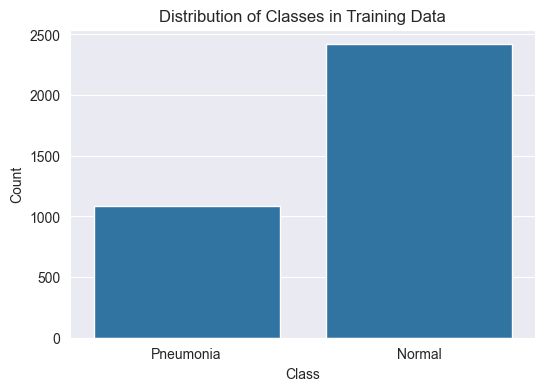

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert labels to class names
l = ["Pneumonia" if label == 1 else "Normal" for label in train_labels]
# Plot class distribution
sns.set_style('darkgrid')
plt.figure(figsize=(6, 4))
sns.countplot(x=l)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Distribution of Classes in Training Data")
plt.show()


**The data seems imbalanced . To increase the no. of training examples, we will use data augmentation**

**Previewing the images of both the classes**

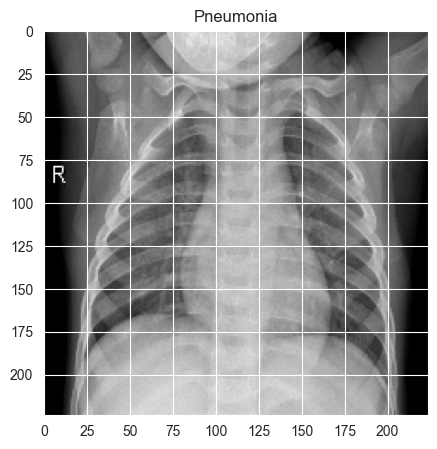

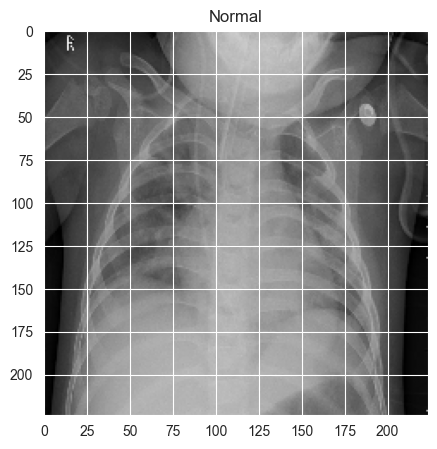

In [11]:
plt.figure(figsize=(5, 5))
plt.imshow(train_images[0], cmap="gray")  # First image
plt.title("Pneumonia" if train_labels[0] == 1 else "Normal")

plt.figure(figsize=(5, 5))
plt.imshow(train_images[-1], cmap="gray")  # Last image
plt.title("Pneumonia" if train_labels[-1] == 1 else "Normal")

plt.show()


In [12]:
# Initialize empty lists
x_train, y_train = [], []
x_test, y_test = [], []

# Split the dataset (Assuming train_images, train_labels exist)
for feature, label in zip(train_images, train_labels):
    x_train.append(feature)
    y_train.append(label)

for feature, label in zip(test_images, test_labels):
    x_test.append(feature)
    y_test.append(label)


# Convert lists to NumPy arrays for compatibility with ML models
import numpy as np
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)
#x_val, y_val = np.array(x_val), np.array(y_val)

print("✅ Data split successfully!")


✅ Data split successfully!


**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [13]:
# Normalize the data
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255
x_val=np.array(x_val) /255

In [14]:
import numpy as np
import cv2  # OpenCV for resizing

img_size = 150  # Define the image size
x_train_resized = [cv2.resize(img, (img_size, img_size)) for img in x_train]
x_test_resized = [cv2.resize(img, (img_size, img_size)) for img in x_test]
x_val_resized = [cv2.resize(img, (img_size, img_size)) for img in x_val]

# Convert to NumPy arrays
x_train = np.array(x_train_resized).reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_test = np.array(x_test_resized).reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

x_val = np.array(x_val_resized).reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

print(f"✅ Data resized and reshaped successfully! New shape: {x_train.shape}")


✅ Data resized and reshaped successfully! New shape: (3507, 150, 150, 1)


In [15]:
# Set up data augmentation for training data only
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit data generator on training data
datagen.fit(x_train)
datagen.fit(x_val)

# Compute class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weights_dict)

# Set up callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Save the best model
checkpoint = ModelCheckpoint(
    'best_pneumonia_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when plateau is reached
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Combine callbacks
callbacks = [checkpoint, early_stopping, reduce_lr]


Class weights: {0: np.float64(1.6101928374655647), 1: np.float64(0.7251861042183623)}


In [16]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset
x_train = x_train.astype('float32') / 255.0  # Normalize pixel values between 0 and 1
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

# Training the Model

In [17]:
from tensorflow.keras.regularizers import l2

In [21]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [22]:
# Define a more balanced model architecture
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
# Input layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Hidden layers
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Flatten and Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Increased dropout to prevent overfitting
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Use Adam optimizer with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Add early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Add to callbacks list when training
callbacks = [learning_rate_reduction, early_stopping]

In [23]:
x_train = np.array(x_train).reshape(-1, 150, 150, 1).astype("float32") / 255.0
y_train = np.array(y_train)

x_val = np.array(x_val).reshape(-1, 150, 150, 1).astype("float32") / 255.0
y_val = np.array(y_val)

In [24]:

# Train model with validation
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=30,
    validation_data=(x_val, y_val),
    class_weight=class_weights_dict,
    callbacks=callbacks,
    verbose=1
)

# Evaluate on test set
results = model.evaluate(x_test, y_test)
test_loss = results[0]  # First value is always loss
test_accuracy = results[1]  # Second value is accuracy

# Generate predictions
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Detailed evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

c:\Users\ASUS\.conda\envs\GPUT\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 55s 432ms/step - accuracy: 0.2881 - loss: -132.8134 - precision_2: 1.0000 - recall_2: 0.9732 - val_accuracy: 0.6793 - val_loss: 218.7569 - val_precision_2: 0.6793 - val_recall_2: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 55s 432ms/step - accuracy: 0.2881 - loss: -132.8134 - precision_2: 1.0000 - recall_2: 0.9732 - val_accuracy: 0.6793 - val_loss: 218.7569 - val_precision_2: 0.6793 - val_recall_2: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 44s 400ms/step - accuracy: 0.3247 - loss: -2538.7251 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.6793 - val_loss: 516.5883 - val_precision_2: 0.6793 - val_recall_2: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 44s 400ms/step - accuracy: 0.3247 - loss: -2538.7251 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.6793 - val_loss: 516.5883 - val_precision_2: 0.6793 - val_recall_2: 1.0000 - learning

c:\Users\ASUS\.conda\envs\GPUT\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\.conda\envs\GPUT\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\.conda\envs\GPUT\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:

# Properly compute and apply class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights (after loading data with consistent labels)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weights_dict)

# When training:
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=15,  # Consider increasing epochs
    validation_data=(x_val, y_val),
    class_weight=class_weights_dict,
    callbacks=[learning_rate_reduction]
)

Class weights: {0: np.float64(1.6101928374655647), 1: np.float64(0.7251861042183623)}


c:\Users\ASUS\.conda\envs\GPUT\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 43s 386ms/step - accuracy: 0.2978 - loss: -1638.5864 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.6793 - val_loss: 167.3636 - val_precision_2: 0.6793 - val_recall_2: 1.0000 - learning_rate: 9.0000e-06
Epoch 2/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 43s 386ms/step - accuracy: 0.2978 - loss: -1638.5864 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.6793 - val_loss: 167.3636 - val_precision_2: 0.6793 - val_recall_2: 1.0000 - learning_rate: 9.0000e-06
Epoch 2/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 43s 390ms/step - accuracy: 0.3123 - loss: -1735.4463 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.6793 - val_loss: 205.4912 - val_precision_2: 0.6793 - val_recall_2: 1.0000 - learning_rate: 9.0000e-06
Epoch 3/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 43s 390ms/step - accuracy: 0.3123 - loss: -1735.4463 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.6793 - val_loss: 205.4912 - val_precision_2: 0.6793 - val_recall_2: 1.0000 - learni

In [ ]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.2972 - loss: 0.7416
Loss of the model is -  0.736605167388916
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.2972 - loss: 0.7416
Accuracy of the model is -  32.04353153705597 %


# Analysis after Model Training

In [ ]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])


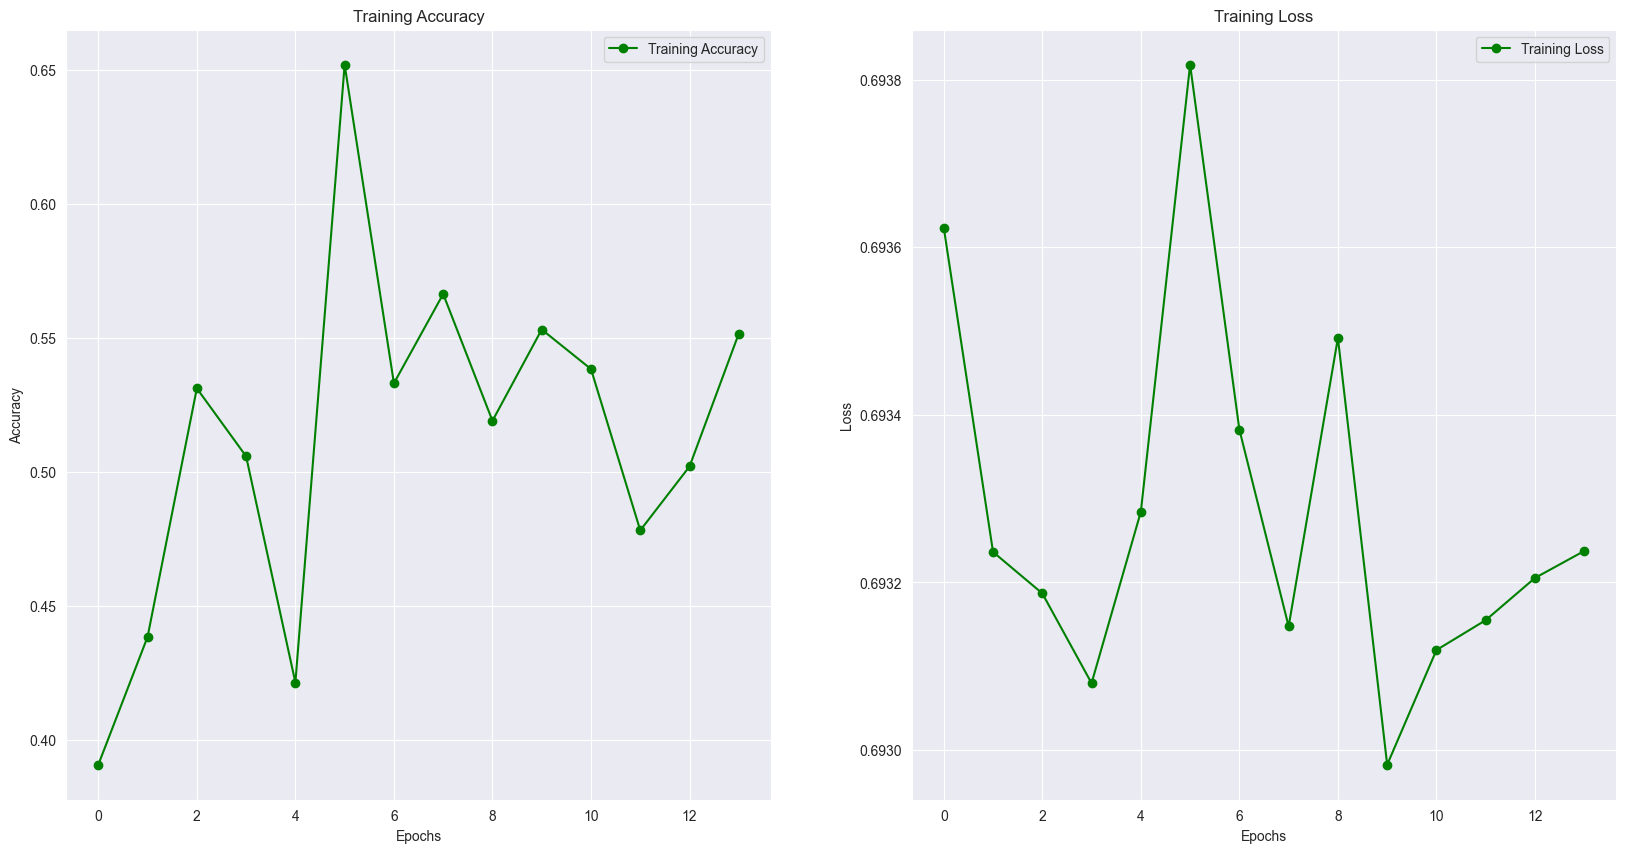

In [ ]:
epochs = range(len(history.history['accuracy']))  # Adjust epochs dynamically

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

train_acc = history.history['accuracy']
train_loss = history.history['loss']

ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].set_title('Training Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
ax[1].set_title('Training Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()


In [ ]:
# Model interpretation with Grad-CAM
# This helps visualize what regions the model is focusing on for classification

def grad_cam(model, img, layer_name='conv2d_4'):
    """
    Generate Grad-CAM visualization for the specified image and layer
    """
    # Create a model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(layer_name).output, model.output]
    )
    
    # Prepare the input image
    img_array = np.expand_dims(img, axis=0)
    
    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Cast the image to float32
        img_array = tf.cast(img_array, tf.float32)
        # Forward pass to get conv output and model prediction
        conv_outputs, predictions = grad_model(img_array)
        # Get the score for the target class (we have binary classification, so index 0)
        score = predictions[:, 0]
    
    # Gradient of the score with respect to the output feature map
    grads = tape.gradient(score, conv_outputs)
    
    # Pooling the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Weight the output feature map with the gradients
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    
    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    
    return heatmap

def display_gradcam(img, heatmap, alpha=0.4):
    """
    Display the original image and the Grad-CAM heatmap overlay
    """
    # Resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # Convert heatmap to RGB and apply colormap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Convert grayscale image to RGB if needed
    if len(img.shape) == 2 or img.shape[2] == 1:
        img = np.squeeze(img)
        img = cv2.cvtColor(np.uint8(img*255), cv2.COLOR_GRAY2RGB)
    
    # Superimpose heatmap on original image
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img / 255.0, 0, 1)
    
    return superimposed_img

# Visualize Grad-CAM for sample validation images
def plot_gradcam_samples(model, x_data, y_true, y_pred, n_samples=4):
    """Plot sample images with their Grad-CAM visualizations"""
    # Find correctly and incorrectly classified examples
    correct_idx = np.where(y_true == y_pred)[0]
    incorrect_idx = np.where(y_true != y_pred)[0]
    
    # Create sampling strategy
    indices = []
    if len(correct_idx) > 0:
        indices.extend(np.random.choice(correct_idx, min(n_samples//2, len(correct_idx)), replace=False))
    if len(incorrect_idx) > 0:
        indices.extend(np.random.choice(incorrect_idx, min(n_samples//2, len(incorrect_idx)), replace=False))
    
    # If we have fewer than n_samples, add more from wherever we can
    if len(indices) < n_samples:
        if len(correct_idx) > len(indices):
            indices.extend(np.random.choice(correct_idx, min(n_samples - len(indices), len(correct_idx)), replace=False))
        elif len(incorrect_idx) > 0:
            indices.extend(np.random.choice(incorrect_idx, min(n_samples - len(indices), len(incorrect_idx)), replace=False))
    
    # Create figure
    plt.figure(figsize=(15, n_samples*4))
    
    for i, idx in enumerate(indices):
        # Get original image
        img = x_data[idx].squeeze()
        
        # Get prediction and true label
        true_label = 'PNEUMONIA' if y_true[idx] == 1 else 'NORMAL'
        pred_label = 'PNEUMONIA' if y_pred[idx] == 1 else 'NORMAL'
        
        # Get Grad-CAM heatmap
        heatmap = grad_cam(model, x_data[idx])
        
        # Create visualization
        cam_image = display_gradcam(img, heatmap)
        
        # Plot original image
        plt.subplot(n_samples, 2, i*2+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Original\nTrue: {true_label}, Pred: {pred_label}")
        plt.axis('off')
        
        # Plot Grad-CAM
        plt.subplot(n_samples, 2, i*2+2)
        plt.imshow(cam_image)
        plt.title("Grad-CAM Visualization")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Generate predictions on validation set
val_preds = (model.predict(x_val) > 0.5).astype(int).flatten()

# Plot Grad-CAM for sample validation images
try:
    plot_gradcam_samples(model, x_val, y_val, val_preds, n_samples=4)
except Exception as e:
    print(f"Error generating Grad-CAM: {e}")
    print("Try using a different layer name in the grad_cam function")

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step
Error generating Grad-CAM: No such layer: conv2d_4. Existing layers are: ['conv2d', 'batch_normalization', 'max_pooling2d', 'conv2d_1', 'batch_normalization_1', 'max_pooling2d_1', 'dropout', 'conv2d_2', 'batch_normalization_2', 'max_pooling2d_2', 'dropout_1', 'flatten', 'dense', 'dropout_2', 'dense_1'].
Try using a different layer name in the grad_cam function


<Figure size 1500x1600 with 0 Axes>

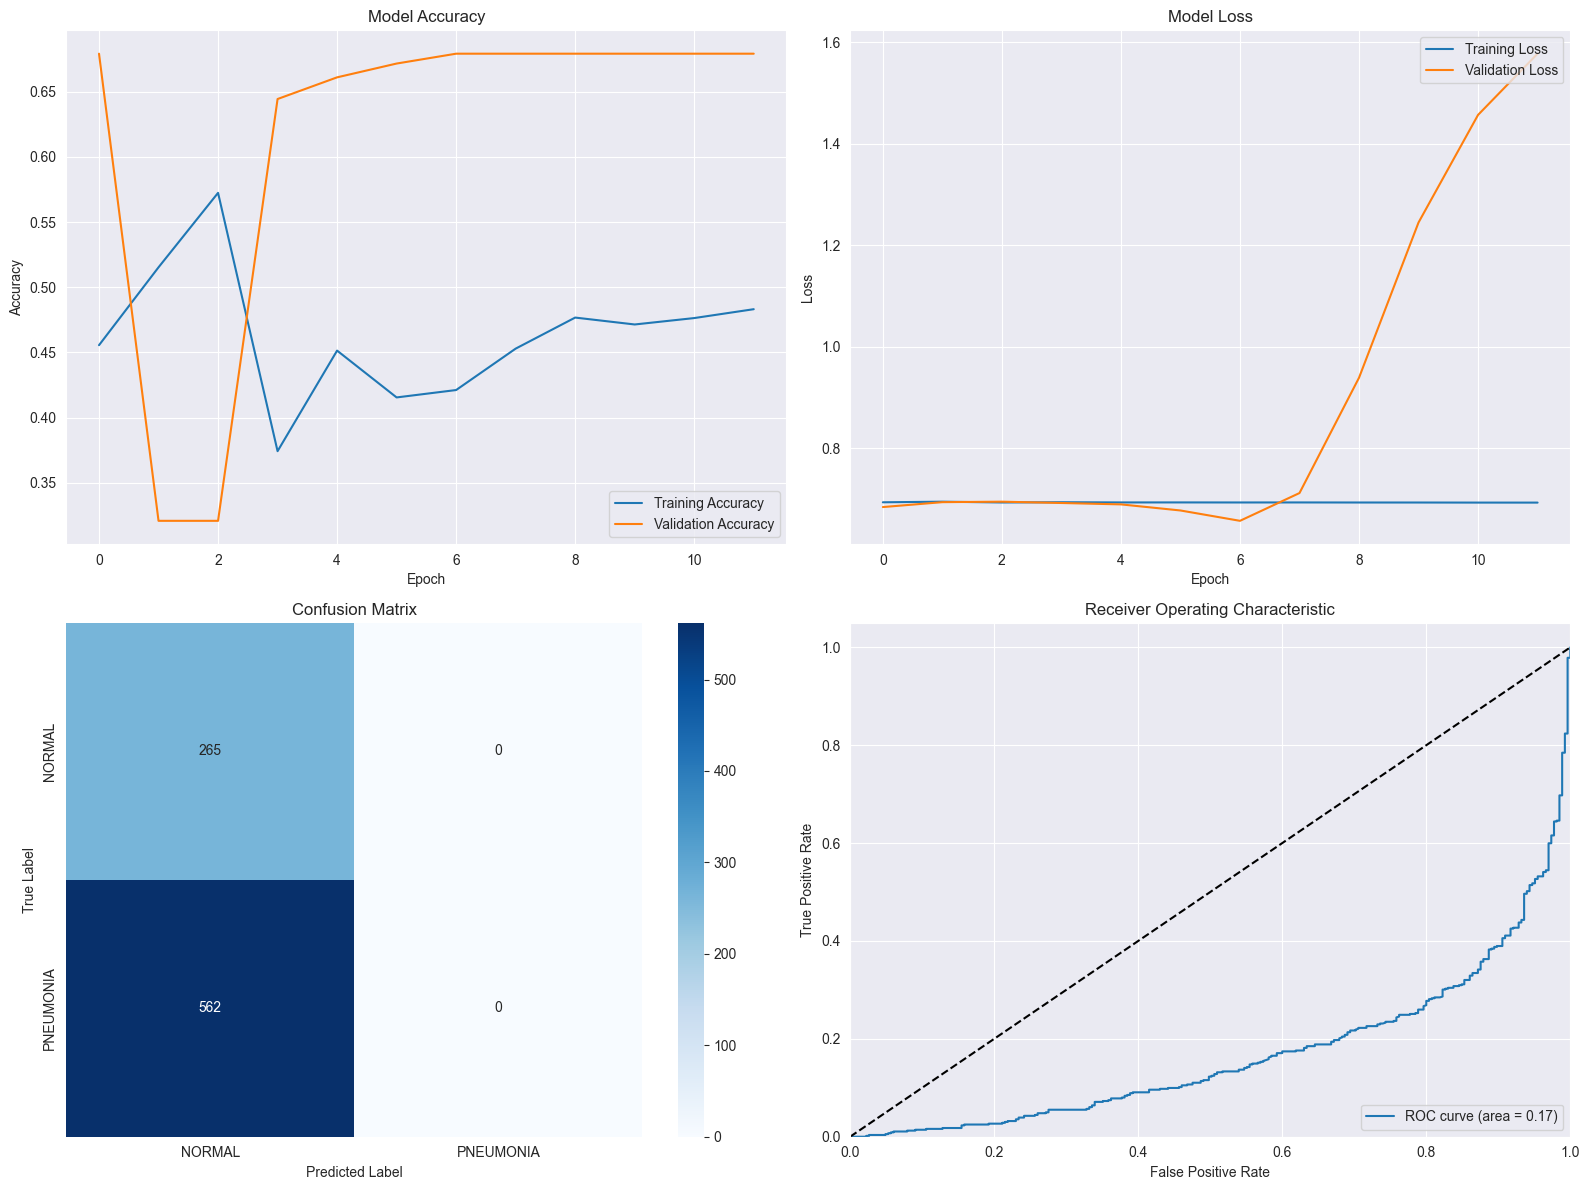

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


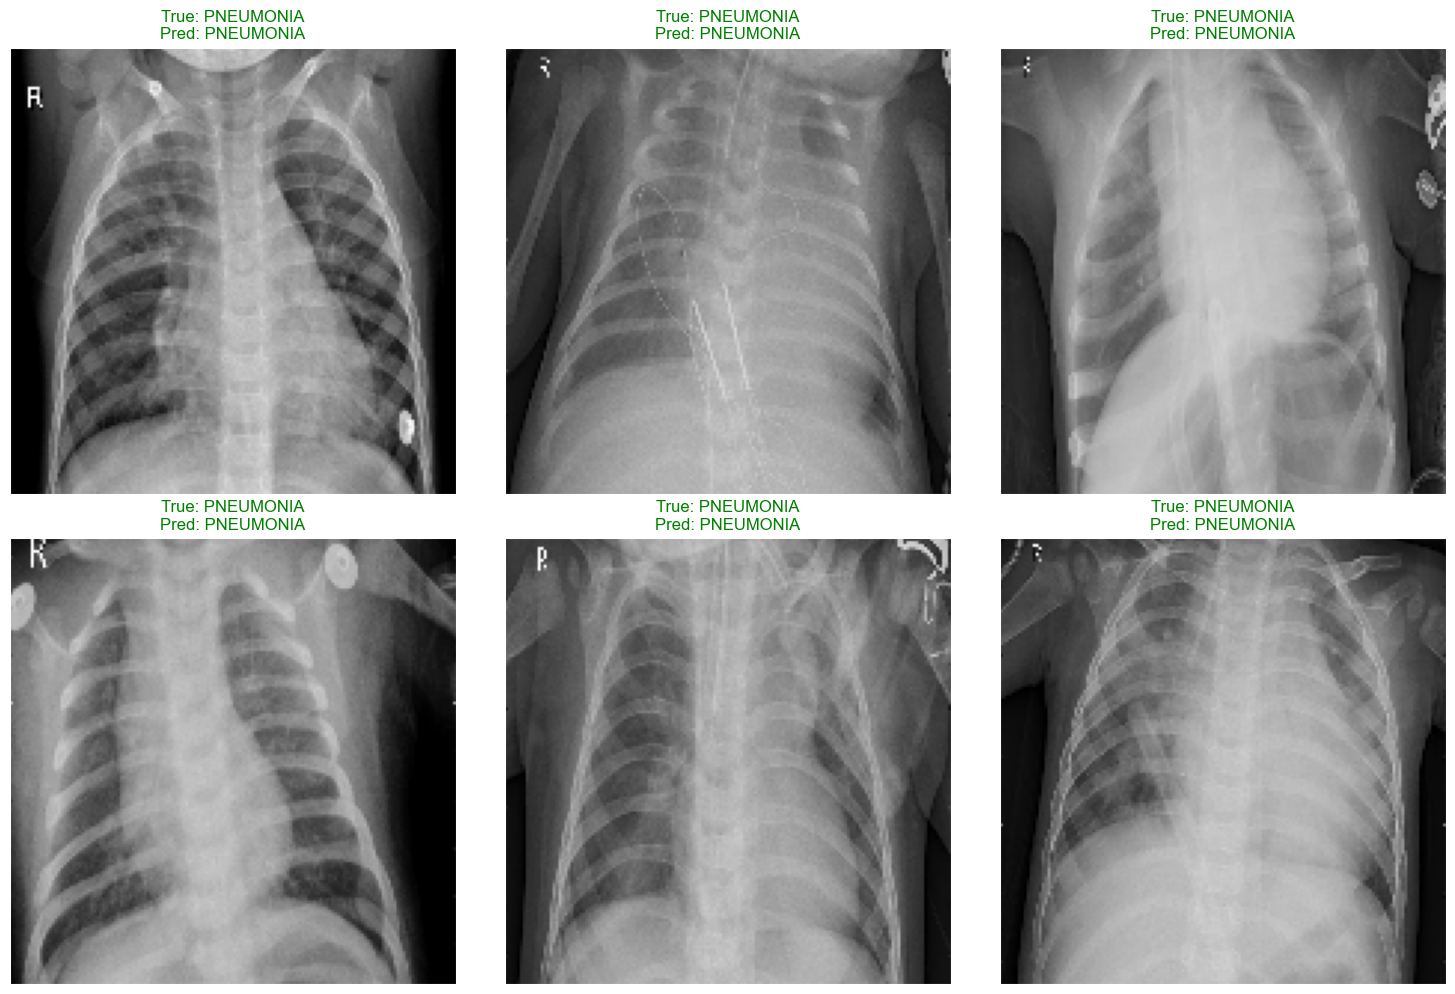

In [ ]:
# Visualize training & validation performance
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
plt.figure(figsize=(16, 12))

# Plot training & validation accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot confusion matrix
plt.subplot(2, 2, 3)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['NORMAL', 'PNEUMONIA'],
            yticklabels=['NORMAL', 'PNEUMONIA'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Plot ROC curve
plt.subplot(2, 2, 4)
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Visualize some predictions on validation set
def plot_sample_predictions(x_data, y_true, y_pred, n_samples=6):
    """Plot sample predictions with their true and predicted labels"""
    # Get random indices
    indices = np.random.choice(range(len(y_true)), n_samples, replace=False)
    
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Plot each sample
    for i, idx in enumerate(indices):
        plt.subplot(2, 3, i+1)
        
        # Get image and convert from (150,150,1) to (150,150)
        img = x_data[idx].squeeze()
        
        # Display image
        plt.imshow(img, cmap='gray')
        
        # Determine color based on correct/incorrect prediction
        color = 'green' if y_true[idx] == y_pred[idx] else 'red'
        
        # Get class names
        true_label = 'PNEUMONIA' if y_true[idx] == 1 else 'NORMAL'
        pred_label = 'PNEUMONIA' if y_pred[idx] == 1 else 'NORMAL'
        
        # Set title with colored text for prediction
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        
        # Remove axis ticks
        plt.xticks([])
        plt.yticks([])
    
    plt.tight_layout()
    plt.show()

# Plot sample predictions
plot_sample_predictions(x_val, y_val, 
                       (model.predict(x_val) > 0.5).astype(int).flatten())

In [ ]:
predictions = model.predict(x_test)  # Get probabilities
predictions = (predictions > 0.5).astype(int)  # Convert probabilities to 0 or 1
predictions = predictions.reshape(-1)  # Flatten to 1D array
print(predictions[:15])  # Show first 15 predictions


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.32      1.00      0.49       265
   Normal (Class 1)       0.00      0.00      0.00       562

           accuracy                           0.32       827
          macro avg       0.16      0.50      0.24       827
       weighted avg       0.10      0.32      0.16       827



c:\Users\ASUS\.conda\envs\GPUT\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\.conda\envs\GPUT\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\.conda\envs\GPUT\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd
# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Convert it into a pandas DataFrame
cm_df = pd.DataFrame(cm, index=['Actual: 0', 'Actual: 1'], columns=['Predicted: 0', 'Predicted: 1'])

# Print the confusion matrix
print(cm_df)

           Predicted: 0  Predicted: 1
Actual: 0           265             0
Actual: 1           562             0


In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

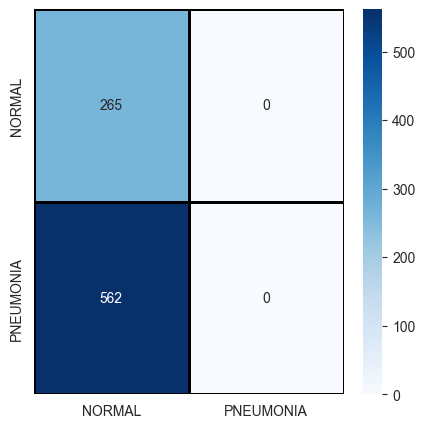

In [ ]:
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

**Some of the Correctly Predicted Classes**

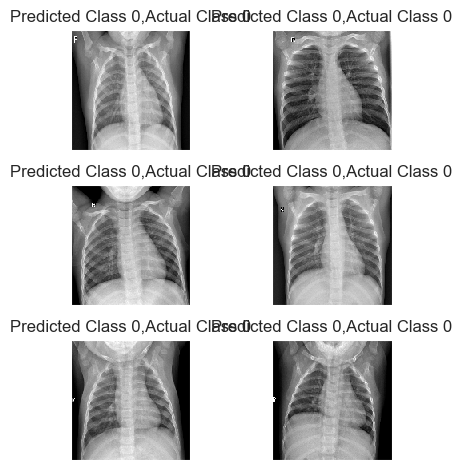

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Some of the Incorrectly Predicted Classes**

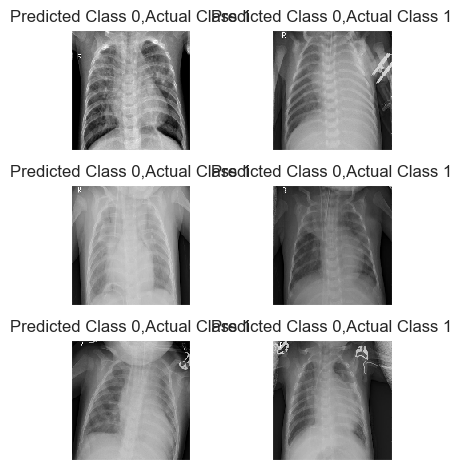

In [ ]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

In [ ]:
# Ensure unbiased evaluation on the test set
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Predict probabilities and classes on the test set
# (x_test, y_test) are from the proper split, not validation or training data
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual: 0 (NORMAL)', 'Actual: 1 (PNEUMONIA)'],
                    columns=['Predicted: 0 (NORMAL)', 'Predicted: 1 (PNEUMONIA)'])
print('Confusion Matrix (Test Set):')
print(cm_df)

# Print classification report for more insight
print('\nClassification Report (Test Set):')
print(classification_report(y_test, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

NameError: name 'model' is not defined